In [1]:
# Establish accounts. Fill out variables here as needed. i.e. project/awardee/pmi_account/service_account
# Once you save this file, you don't have to retype these.

project = "all-of-us-rdr-stable" # type in environment if not stable
awardee = "PITT" # fill in your awardee
pmi_account = "michael.mead@pmi-ops.org" # update your pmi-ops account.
#service_account = "awardee-XXX@all-of-us-ops-data-api-stable.iam.gserviceaccount.com" #update to your service account
service_account = "configurator@all-of-us-rdr-stable.iam.gserviceaccount.com"

In [2]:
# Authentication. This cell creates a key for your service account, you don't need to do anything.
import re
import os
results = !gcloud -q iam service-accounts keys create --account $pmi_account --project $project --iam-account $service_account gcloud_key.json
print(results)
key_id = re.search('.*?\[(.*?)\]', results[0]).groups()[0]
print("Google Key ID: {0}".format(key_id))
!gcloud -q auth activate-service-account --key-file=gcloud_key.json

['created key [b056b8d0d49958adea4b0227ee0de775ba9be324] of type [json] as [gcloud_key.json] for [configurator@all-of-us-rdr-stable.iam.gserviceaccount.com]']
Google Key ID: b056b8d0d49958adea4b0227ee0de775ba9be324
Activated service account credentials for: [configurator@all-of-us-rdr-stable.iam.gserviceaccount.com]


Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update



In [3]:
# Get Oauth Token, refresh as needed.
token = !gcloud -q auth print-access-token
token = token[0]
headers = {'content-type': 'application/json', 'Authorization': 'Bearer {0}'.format(token)}
print('Authentication Token Ready!') if token.startswith('ya') else 'Authentication Token Error!'

Authentication Token Ready!


In [4]:
# Make request to get API version. This is the current RDR version for reference
import requests
resp = requests.get('http://all-of-us-rdr-stable.appspot.com/rdr/v1/', headers=headers)
print(resp.json())

{'version_id': '1-62-1'}


In [7]:
# Request first 25 participants by default. You can change parameters of the url as needed.
# See https://github.com/all-of-us/raw-data-repository/blob/master/opsdataAPI.md for documentation of this api.

url = 'https://{0}.appspot.com/rdr/v1/ParticipantSummary?_sort=lastModified&_count=25&awardee={1}'.format(project, awardee)

resp = requests.get(url, headers=headers)
if not resp or resp.status_code != 200:
    print('Error: api request failed.\n\n{0}.'.format(resp.text if resp else 'Unknown error.'))
else:
    ps_data = resp.json()
    print('Success: retrieved {0} records.'.format(len(ps_data['entry'])))

Success: retrieved 25 records.


(array([ 0.,  0.,  0., 25.,  0.,  0.]),
 array([4.5       , 4.66666667, 4.83333333, 5.        , 5.16666667,
        5.33333333, 5.5       ]),
 <a list of 6 Patch objects>)

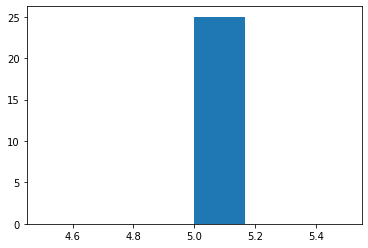

In [8]:
# This cell creates a dataframe to show a graphical representation of what is returned.
from datetime import datetime
import pandas
import matplotlib.pyplot as plt
%matplotlib inline 

good_cols = ['ageRange', 'dateOfBirth', 'participantId', 'race', 'sex']

data = []

# loop over participant summary records, insert participant data in same order as good_cols.
for entry in ps_data['entry']:
    item = []
    for col in good_cols:
        for key, val in entry['resource'].items():
            if col == key:
                if key == 'dateOfBirth':                    
                    item.append(datetime.strptime(val, '%Y-%m-%d'))
                else:
                    item.append(val)    
    data.append(item)
    
frame = pandas.DataFrame(data, columns=good_cols)
# print(frame)
# print(frame["dateOfBirth"].value_counts())
plt.hist(frame["dateOfBirth"].dt.weekday, bins=6)
# plt.hist(frame["dateOfBirth"].dt.year, bins=20)

In [9]:
# Deletes the google cloud key created in first step so that you don't hit the Google enforced limit of 10 keys.
import os
os.remove('gcloud_key.json')
!gcloud -q iam service-accounts keys delete $key_id --account $pmi_account --iam-account $service_account

deleted key [b056b8d0d49958adea4b0227ee0de775ba9be324] for service account [configurator@all-of-us-rdr-stable.iam.gserviceaccount.com]


###NOTES:
* Cells will be added/modified by the dev team while working with data stewards to determine specific needs.
* You are welcome to add cells to view info in different ways if you're comfortable with Python
    * if you ever want to return this notebook to it's original state type `git checkout -- ops_data_api.ipynb` from the ops_data_api directory.